### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

%matplotlib inline

### Functions

In [2]:
def to_torch(X,reshape=False):
    if reshape: 
        return torch.from_numpy(X.astype(np.float32).reshape(-1,1))
    else:
        return torch.from_numpy(X.astype(np.float32))


def create_model_and_load(path,logit):
    if not logit:
        model = nn.Sequential(
            nn.Linear(D,1),
            nn.Sigmoid()
        )
    else:
        model = nn.Sequential(
            nn.Linear(D,1)
        )

    model.load_state_dict(torch.load(path))
    
    return model


def create_model_and_train(X_train,Y_train,X_test,Y_test,D,logit=False,n_epochs=100):
    
    if not logit:
        model = nn.Sequential(
            nn.Linear(D,1),
            nn.Sigmoid()
        )
        criterion = nn.BCELoss()
    else:
        model = nn.Sequential(
            nn.Linear(D,1)
        )
        criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    inputs  = to_torch(X_train,reshape=False)
    targets = to_torch(Y_train,reshape=True)
    
    test_inputs  = to_torch(X_test,reshape=False)
    test_targets = to_torch(Y_test,reshape=True)    
    
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    train_accs = np.zeros(n_epochs)
    test_accs = np.zeros(n_epochs)
    
    
    for it in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        train_losses[it]=loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        #test
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_targets)
        test_losses[it]=test_loss.item() 
        
        train_accs[it]= model_result_printer(model,targets,predict_model(model,outputs,mode=1,logit=logit),usage="in",metrics_lists=[metrics.accuracy_score])[0]
        test_accs[it] = model_result_printer(model,test_targets,predict_model(model,test_outputs,mode=1,logit=logit),usage="in",metrics_lists=[metrics.accuracy_score])[0]
        
        
        if it%100==0:
            print("{:20}".format(f"epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}"))
        
    return model ,train_losses, test_losses, train_accs, test_accs


def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def predict_model(model,X,mode=0,logit=False):
    if mode==0:
        if logit:
            pred = np.where(model(torch.from_numpy(X).float()).detach().numpy() > 0, 1, 0)   
        else:
            pred = np.round(model(torch.from_numpy(X).float()).detach().numpy())
            
    elif mode==1:
        if logit:
            pred = np.where(X.detach().numpy() > 0, 1, 0)
        else:
            pred = np.round(X.detach().numpy())
        

    return pred


def model_result_printer(model,y_test,y_pred,usage="in",mode="test",metrics_lists=[metrics.accuracy_score,metrics.f1_score,metrics.precision_score,metrics.recall_score],metric_names=["acc","f1","precision","recall"]):
    metric_values = []
    if usage=="out":
        print(f"-------{mode}-------")
    for metric in range(len(metrics_lists)):
        metric_value = metrics_lists[metric](y_test, y_pred)
        if usage=="out":
            print("{:20}".format("{}: ".format(metric_names[metric])),metric_value)
        elif usage=="in":
            metric_values.append(metric_value)

    if usage=="in":       
        return metric_values

### Data loading

In [3]:
data = load_breast_cancer()
print(type(data))

<class 'sklearn.utils.Bunch'>


In [4]:
print(data.keys())

print(data["data"].shape)
print(data.target.shape)

print(data.target_names)
print(data.feature_names)

# or data.data.shape and data.target.shape

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
(569, 30)
(569,)
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3)

N, D = X_train.shape

### Normalization

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Some plots

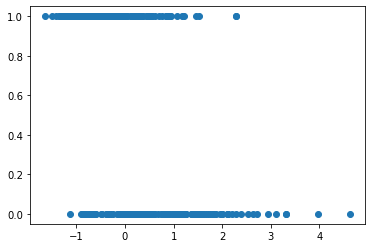

In [7]:
plt.scatter(X_train[:,5],y_train);
# print(X_train[:,0])

### Model train & test

In [16]:
# loss = logit / simple
logit = False
model ,train_losses, test_losses , train_accs, test_accs= create_model_and_train(X_train,y_train,X_test,y_test,D,logit=logit,n_epochs=1000)

epoch 1/1000, Train Loss: 0.8318, Test Loss: 0.8043
epoch 101/1000, Train Loss: 0.3787, Test Loss: 0.3585
epoch 201/1000, Train Loss: 0.2541, Test Loss: 0.2477
epoch 301/1000, Train Loss: 0.1987, Test Loss: 0.1987
epoch 401/1000, Train Loss: 0.1671, Test Loss: 0.1707
epoch 501/1000, Train Loss: 0.1466, Test Loss: 0.1524
epoch 601/1000, Train Loss: 0.1321, Test Loss: 0.1396
epoch 701/1000, Train Loss: 0.1213, Test Loss: 0.1301
epoch 801/1000, Train Loss: 0.1130, Test Loss: 0.1227
epoch 901/1000, Train Loss: 0.1063, Test Loss: 0.1167


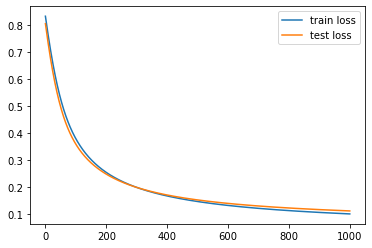

In [17]:
plot_test_and_train_metric(train_losses, test_losses,"loss")

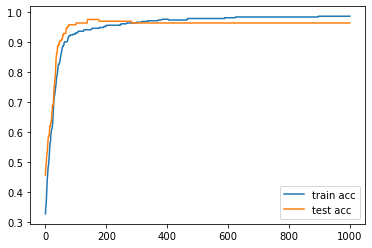

In [18]:
plot_test_and_train_metric(train_accs, test_accs,"acc")

In [19]:
y_pred_train = predict_model(model,X_train,logit=logit)
model_result_printer(model,y_train,y_pred_train,usage="out",mode="train")

y_pred_test = predict_model(model,X_test,logit=logit)
model_result_printer(model,y_test,y_pred_test,usage="out",mode="test")

-------train-------
acc:                 0.9874371859296482
f1:                  0.98989898989899
precision:           0.9839357429718876
recall:              0.9959349593495935
-------test-------
acc:                 0.9649122807017544
f1:                  0.9734513274336283
precision:           0.9565217391304348
recall:              0.990990990990991


### Save and Load model

In [20]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3199, -0.4352, -0.2508, -0.4498, -0.1487, -0.1242, -0.4825, -0.2417,
                       -0.1269,  0.5575, -0.1961, -0.1617, -0.2230, -0.1839,  0.1785, -0.0316,
                        0.2590, -0.3027,  0.1366,  0.5082, -0.5066, -0.3118, -0.3760, -0.2430,
                       -0.5499, -0.1308, -0.3566, -0.2133, -0.3634, -0.3062]])),
             ('0.bias', tensor([0.6403]))])

In [21]:
path = "./model/classification_model.pt"
torch.save(model.state_dict(),path)

In [22]:
# Load model
loaded_model = create_model_and_load(path,logit)

In [23]:
y_pred_train = predict_model(loaded_model,X_train,logit=logit)
model_result_printer(loaded_model,y_train,y_pred_train,usage="out",mode="train")

y_pred_test = predict_model(loaded_model,X_test,logit=logit)
model_result_printer(loaded_model,y_test,y_pred_test,usage="out",mode="test")

-------train-------
acc:                 0.9874371859296482
f1:                  0.98989898989899
precision:           0.9839357429718876
recall:              0.9959349593495935
-------test-------
acc:                 0.9649122807017544
f1:                  0.9734513274336283
precision:           0.9565217391304348
recall:              0.990990990990991


In [24]:
# Download in colab - upload is the same

# from google.cloab import files
# files.download(path)